In [5]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
import shap

In [9]:
'''
THE AIM OF THIS DATASET IS TO CHECK IF THE PERSON IS MAKING MORE THAN $50K PER YEAR OR NOT
'''

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

In [7]:
print(X)

        Age  Workclass  Education-Num  Marital Status  Occupation  \
0      39.0          7           13.0               4           1   
1      50.0          6           13.0               2           4   
2      38.0          4            9.0               0           6   
3      53.0          4            7.0               2           6   
4      28.0          4           13.0               2          10   
...     ...        ...            ...             ...         ...   
32556  27.0          4           12.0               2          13   
32557  40.0          4            9.0               2           7   
32558  58.0          4            9.0               6           1   
32559  22.0          4            9.0               4           1   
32560  52.0          5            9.0               2           4   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0                 0     4    1        2174.0           0.0            40.0   
1              

In [8]:
print(y)

[False False False ... False False  True]


In [10]:
'''
USING DMatrix, WHICH CAN BE USED IN GRADIENT BOOSTING AND XGBOOST,
DMatrix: Data is converted into a Compressed Sparse Row (CSR) format. 
IT MAKES MOST VALUES ZERO, SO IT HAS TO ONLY REMEMBER THE 1'S VALUE, [Cache Locality] --> THIS MAKES XGBOOST EVEN FASTER (MOSTLY USED IN COMPITITIONS LIKE KAGGLE).
IF WE USE DMatrix, WE CANNOT USE .FIT AND .PREDICT.
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [11]:
params = {
    "eta": 0.01,                        # learning rate
    "objective": "binary:logistic",     # specifying that it is a binary classifying problem
    "subsample": 0.5,                   # specifying to use half to the traing set, (note : subsample = 1.0 creates overfitting and subsample = 0.1 creates underfitting model)
    "base_score": np.mean(y_train),     # providing a starting value to train on (initial value)
    "eval_metric": "logloss",
}
model = xgboost.train(
    params,
    d_train,
    5000,                               # max rounds
    evals=[(d_test, "test")],            
    verbose_eval=100,                   # verify and print after 100 rounds
    early_stopping_rounds=20,           # if there is no change after 20 rounds stop
)

[0]	test-logloss:0.54656
[100]	test-logloss:0.36371
[200]	test-logloss:0.31800
[300]	test-logloss:0.30030
[400]	test-logloss:0.29155
[500]	test-logloss:0.28649
[600]	test-logloss:0.28342
[700]	test-logloss:0.28164
[800]	test-logloss:0.28044
[900]	test-logloss:0.27944
[1000]	test-logloss:0.27896
[1100]	test-logloss:0.27847
[1126]	test-logloss:0.27849


In [17]:
y_pred_prob = model.predict(d_test)
y_pred = (y_pred_prob > 0.5).astype(int) 

from sklearn.metrics import  classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.90      0.94      0.92      4951
        True       0.79      0.65      0.71      1562

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.82      6513
weighted avg       0.87      0.87      0.87      6513



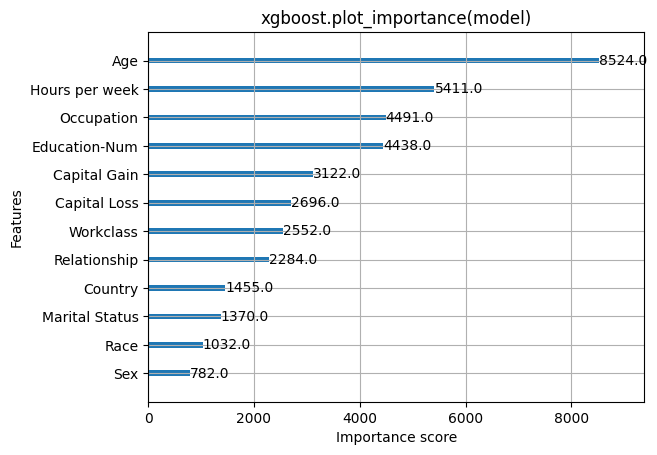

In [18]:
xgboost.plot_importance(model,importance_type="weight")  # weight is, how many times a specific feature was used to split the data across all the trees 
pl.title("xgboost.plot_importance(model)")
pl.show()

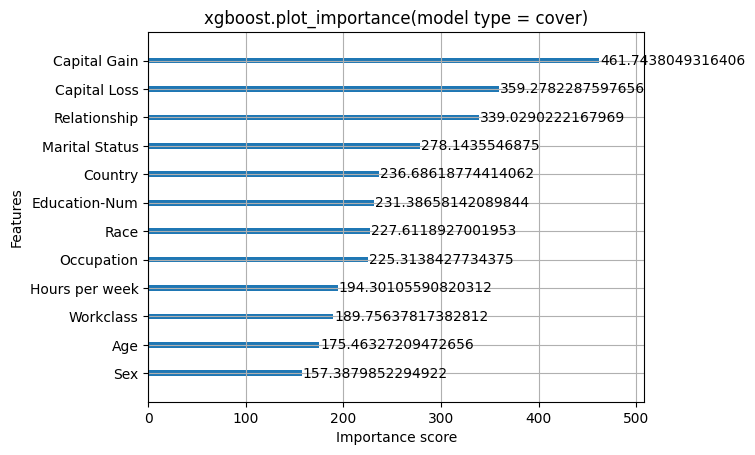

In [23]:
xgboost.plot_importance(model, importance_type="cover") # Cover tells you how many samples (observations) were affected by the splits involving that feature.
pl.title('xgboost.plot_importance(model type = cover)')
pl.show()

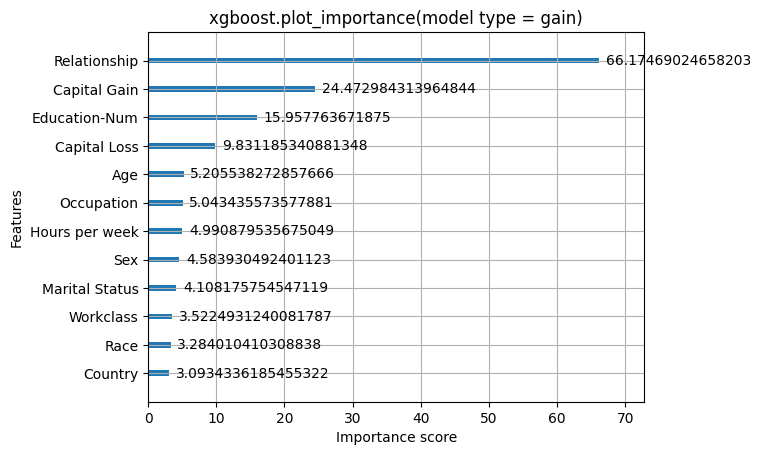

In [22]:
xgboost.plot_importance(model, importance_type="gain")  # gain : It calculates the difference between the error (loss) before the split and the sum of the errors after the split.
pl.title('xgboost.plot_importance(model type = gain)')
pl.show()

In [24]:
explainer = shap.TreeExplainer(model) # TreeExplainer is a high-speed version of SHAP specifically designed for tree-based models like XGBoost.
shap_values = explainer.shap_values(X) #For every single row in your dataset X, SHAP calculates a value for every feature.If you have 1,000 rows and 10 features, shap_values is a matrix of 1,000 times 10.

In [26]:
shap.initjs()  # NECESSARY FOR VISUALIZATION (it is generally used in jupyter notebook to plot shap graphs (loads JS file, so we can plot graphs) )

In [28]:
shap.force_plot(explainer.expected_value, shap_values[10, :], X_display.iloc[10, :])  # checking out the 10th person

In [37]:
# plottinh the values for top 100 people

shap.force_plot(
    explainer.expected_value, shap_values[:100, :], X_display.iloc[:100, :]
)

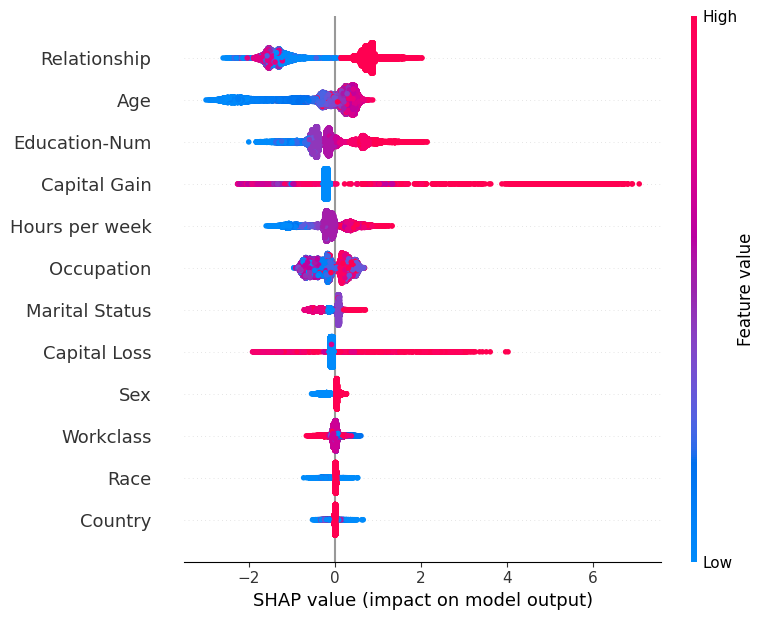

In [35]:
shap.summary_plot(shap_values, X)  # bee swarm plot

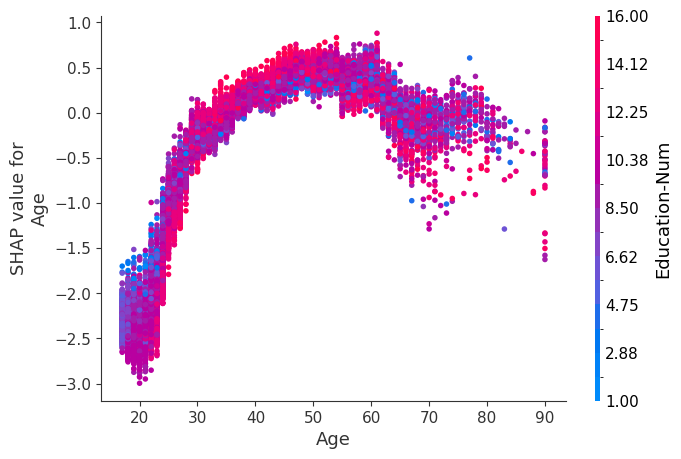

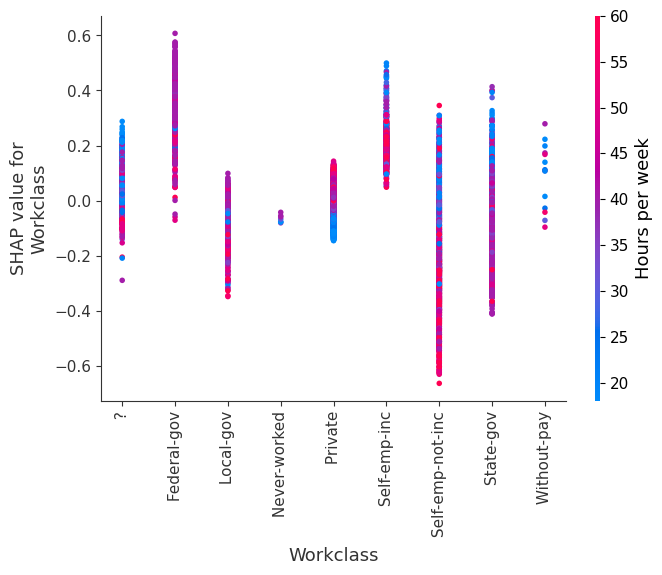

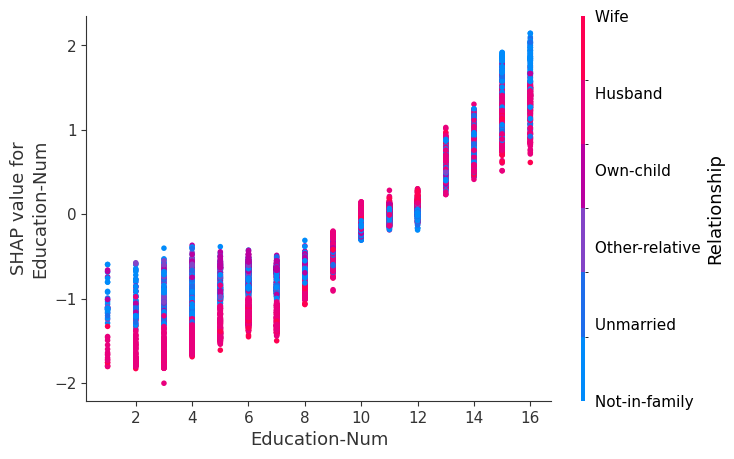

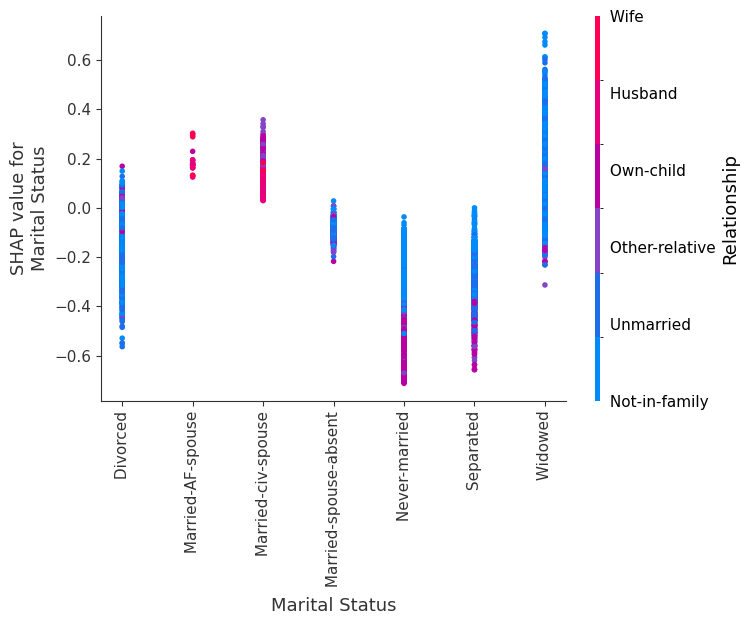

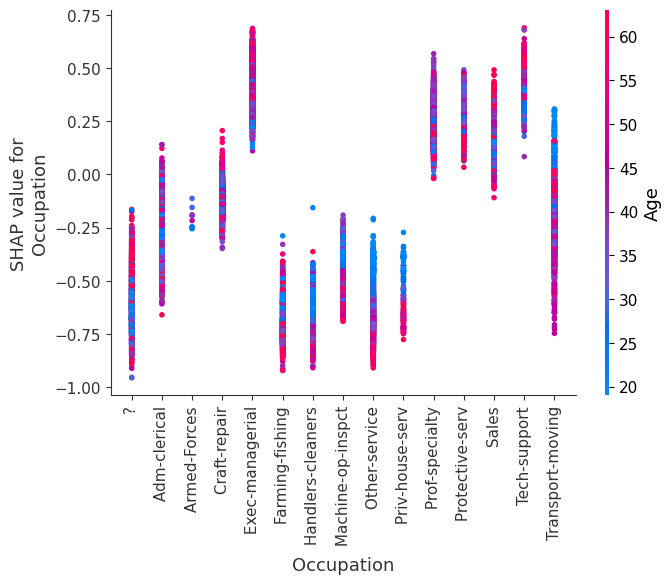

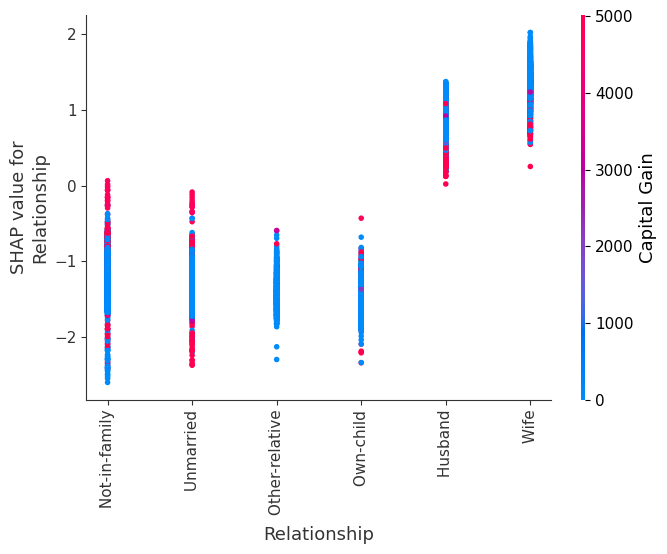

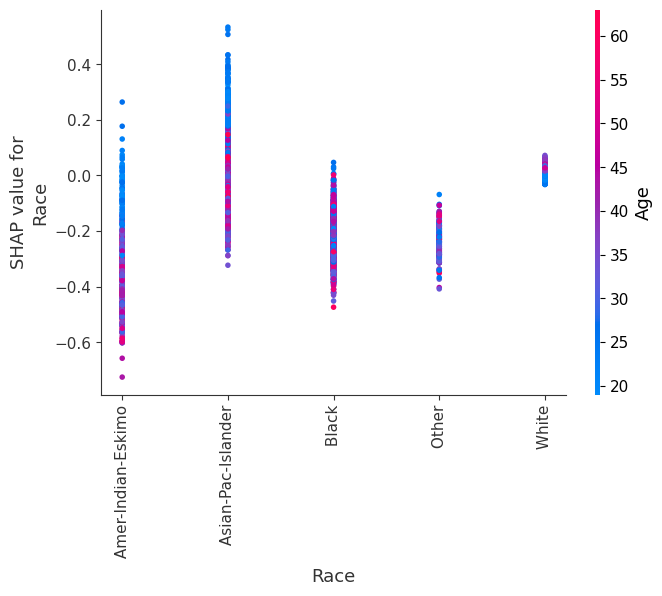

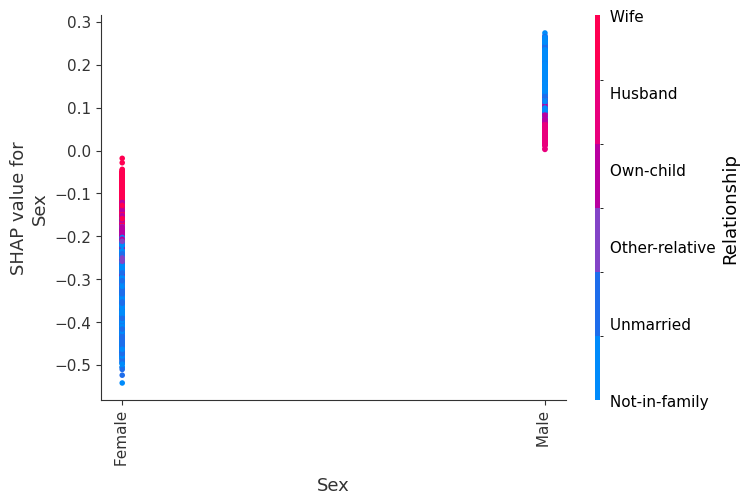

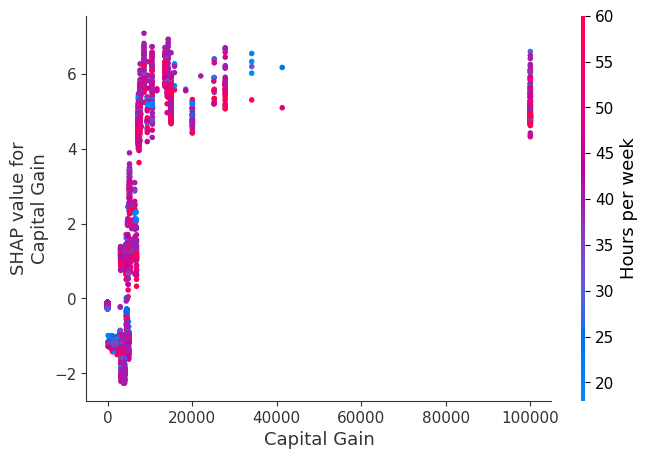

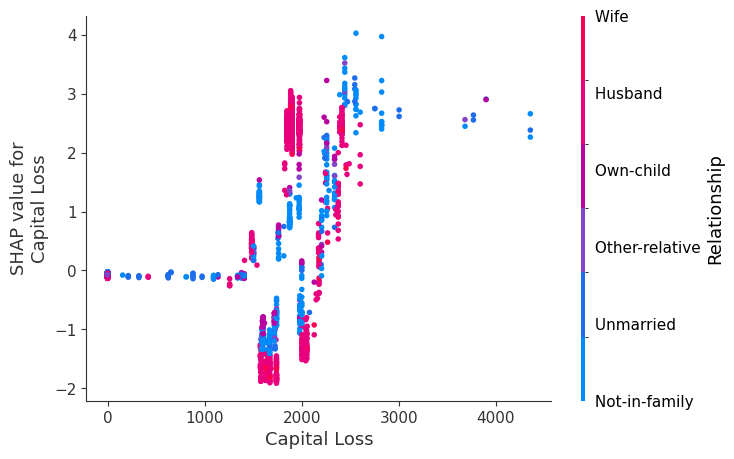

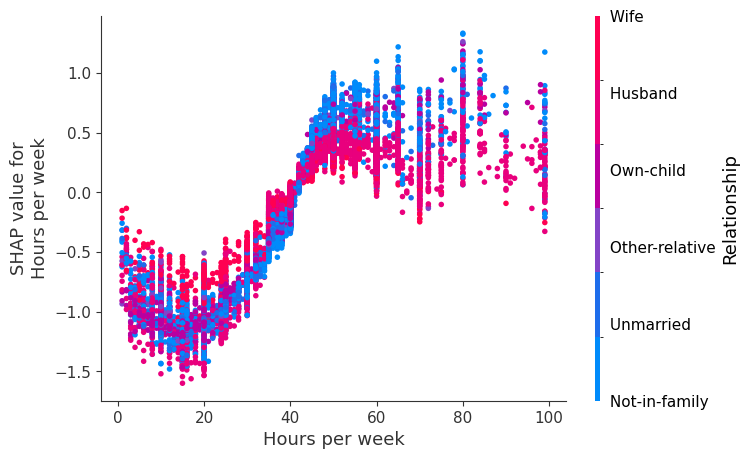

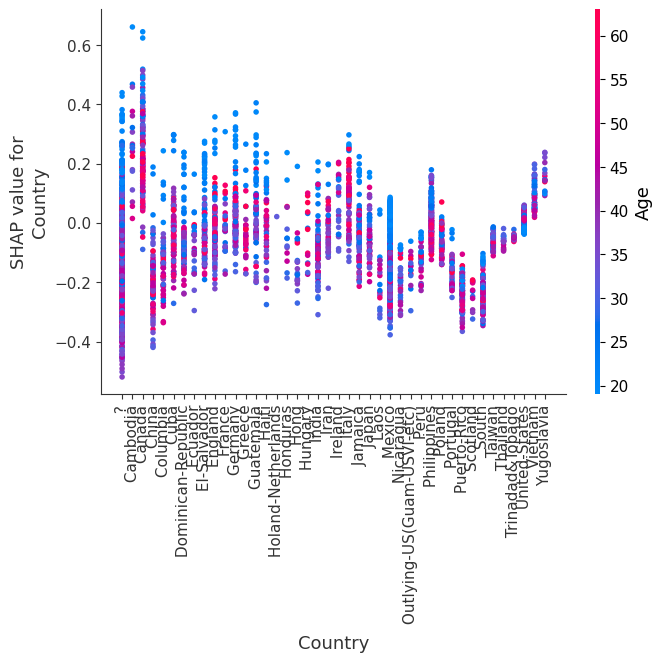

In [36]:
for name in X_train.columns:
    shap.dependence_plot(name                            # x axis
                         , shap_values                   #y axis
                         , X                             #raw data
                         , display_features=X_display    # data in human readable form
                        )